In [0]:
import torch
import torchvision
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image

In [0]:
from google.colab import drive
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [0]:
device = torch.device("cuda")

normalize3 = torchvision.transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
transforms3 = torchvision.transforms.Compose([torchvision.transforms.ToTensor(), normalize3])
transforms1 = torchvision.transforms.Compose([torchvision.transforms.ToTensor()])

In [0]:
deeplab_rgbe2coco = torch.load('/content/gdrive/My Drive/Potsdam/deeplab_resnet101_rgbe2coco.pth').to(device)

In [0]:
if False:
  rgb_data = Image.open('/content/gdrive/My Drive/Potsdam/Validation/top_potsdam_2_12_RGB.tif')
  elevation_data = Image.open('/content/gdrive/My Drive/Potsdam/Validation/dsm_potsdam_02_12_normalized_lastools.jpg')
  label_data = Image.open('/content/gdrive/My Drive/Potsdam/Validation/top_potsdam_2_12_label.tif')
else:
  rgb_data = Image.open('/content/gdrive/My Drive/Potsdam/Validation/top_potsdam_5_11_RGB.tif')
  elevation_data = Image.open('/content/gdrive/My Drive/Potsdam/Validation/dsm_potsdam_05_11_normalized_lastools.jpg')
  label_data = Image.open('/content/gdrive/My Drive/Potsdam/Validation/top_potsdam_5_11_label.tif')

In [0]:
def transmute_to_classes(window):
  # 2 = tree
  # 3 = ground
  # 4 = clutter
  # 1 = building
  # 5 = car
  # 0 = everything else
  retval = (4*(window[:, :, 0]/0xff).astype(np.long) + 2*(window[:, :, 1]/0xff).astype(np.long) + 1*(window[:, :, 2]/0xff).astype(np.long))
  cars = (retval == 6)
  not_cars = (retval != 6)
  retval = (retval * not_cars) + 5*cars
  retval = retval * (retval < 6)
  return retval

def potsdam_eval_window(x, y, rgb_data, elevation_data, label_data):
  size = 500
  box = (x, y, x + size, y + size)
  rgb_window = rgb_data.crop(box)
  elevation_window = elevation_data.crop(box)
  labels_window = np.array(label_data.crop(box))
  labels_window = transmute_to_classes(labels_window)
  return (rgb_window, elevation_window, labels_window)

def potsdam_eval_batch(x, y, rgb_ar, elevation_ar, labels_ar):
  batch_size = 1
  
  rgbs = []
  elvs = []
  labs = []
  
  for i in range(batch_size):
    rgb, elv, lab = potsdam_eval_window(x, y, rgb_ar, elevation_ar, labels_ar)

    rgbs.append(transforms3(rgb))
    elvs.append(transforms1(elv))
    labs.append(torch.unsqueeze(torch.from_numpy(lab), 0))

  rgbs = torch.stack(rgbs).to(device)
  elvs = torch.stack(elvs).to(device)
  labs = torch.cat(labs, dim=0).to(device)
  rgbes = torch.cat([rgbs, elvs], dim=1)

  return (rgbes, labs)


In [0]:
from torch import nn
from collections import OrderedDict

class DeepLabWrapper(nn.Module):
   def __init__(self, m):
      super(DeepLabWrapper, self).__init__()
      self.m = m

   def forward(self, X):
      return self.m(X)['out']

    
RECURSE_WHITE_LIST = (nn.Sequential, nn.ModuleList, DeepLabWrapper, torchvision.models._utils.IntermediateLayerGetter, torchvision.models.resnet.Bottleneck)
RECURSE_WHITE_LIST = (nn.Sequential, nn.ModuleList, DeepLabWrapper, torchvision.models._utils.IntermediateLayerGetter, torchvision.models.segmentation.deeplabv3.DeepLabHead)

def attach_forward_hooks(m, callback, depth=0, max_depth=3, recurse_whitelist=(nn.Sequential, nn.ModuleList)):
   print('{} at depth {}'.format(type(m), depth))
   if depth > max_depth:
      return []
   hs = []
   for c in m.children():
      if isinstance(c, recurse_whitelist):
         hs += attach_forward_hooks(c, callback, depth=depth+1, max_depth=max_depth, recurse_whitelist=recurse_whitelist)
      else:
         hs.append(c.register_forward_hook(callback))
   return hs


def viz_model_run(model, model_input, hook_callback, max_depth=2, recurse_whitelist=(nn.Sequential, nn.ModuleList)):
   hs = []
   model.eval()
   try:
      hs = attach_forward_hooks(model, hook_callback, max_depth=max_depth, recurse_whitelist=recurse_whitelist)
      with torch.no_grad():
         out = model(model_input)
   finally:
      for h in hs:
         h.remove()
   return out


def viz_conv_layer_output(module, _, output):
   if isinstance(output, OrderedDict):  # handle deeplab
      output = output['out']
   fs = output.detach().cpu().permute(1, 0, 2, 3)

   print('Layer:', module)
   # print('Output shape:', fs.shape)
   # print(type(module))

   normalize = not (fs.shape[-1] == 1 and fs.shape[-2] == 1)
   grid = torchvision.utils.make_grid(fs, nrow=int(len(fs)**0.5), normalize=normalize, scale_each=normalize, padding=2).permute(1, 2, 0)

   plt.figure(figsize=(12, 12))
   plt.imshow(grid, cmap='gray')
   plt.axis('off')
   plt.show()


def model_debug(model, batch_tensor, flatten_seqs=False, max_depth=2, recurse_whitelist=RECURSE_WHITE_LIST):
   out = viz_model_run(model, batch_tensor[0], viz_conv_layer_output, max_depth=max_depth, recurse_whitelist=recurse_whitelist)


In [0]:
model = DeepLabWrapper(deeplab_rgbe2coco)

In [0]:
batch_tensor = potsdam_eval_batch(1470, 2900, rgb_data, elevation_data, label_data)

In [0]:
batch_tensor[0].shape

torch.Size([1, 4, 500, 500])

<class 'torchvision.models.segmentation.deeplabv3.DeepLabV3'> at depth 0
<class 'torchvision.models._utils.IntermediateLayerGetter'> at depth 1
<class 'torch.nn.modules.container.Sequential'> at depth 2
<class 'torch.nn.modules.container.Sequential'> at depth 2
<class 'torch.nn.modules.container.Sequential'> at depth 2
<class 'torch.nn.modules.container.Sequential'> at depth 2
<class 'torchvision.models.segmentation.deeplabv3.DeepLabHead'> at depth 1
<class 'torchvision.models.segmentation.fcn.FCNHead'> at depth 1
Layer: Conv2d(4, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)


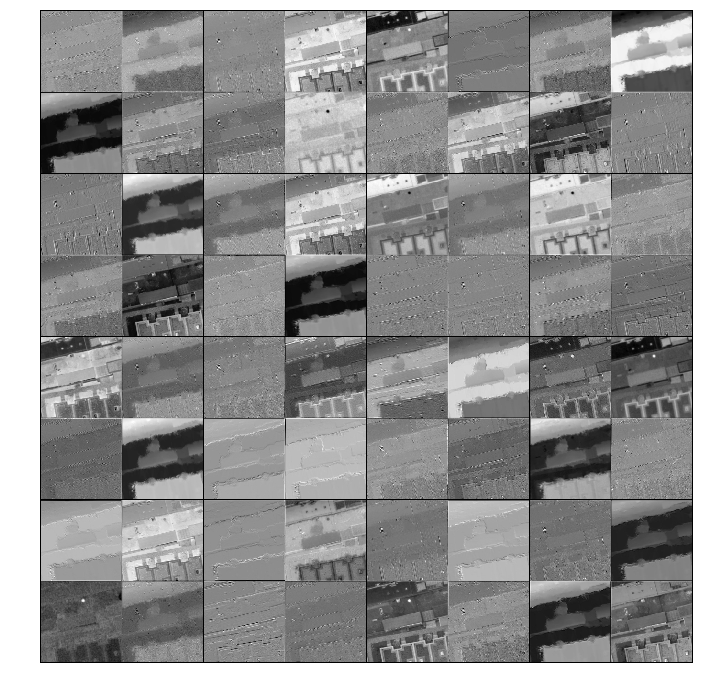

Layer: BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)


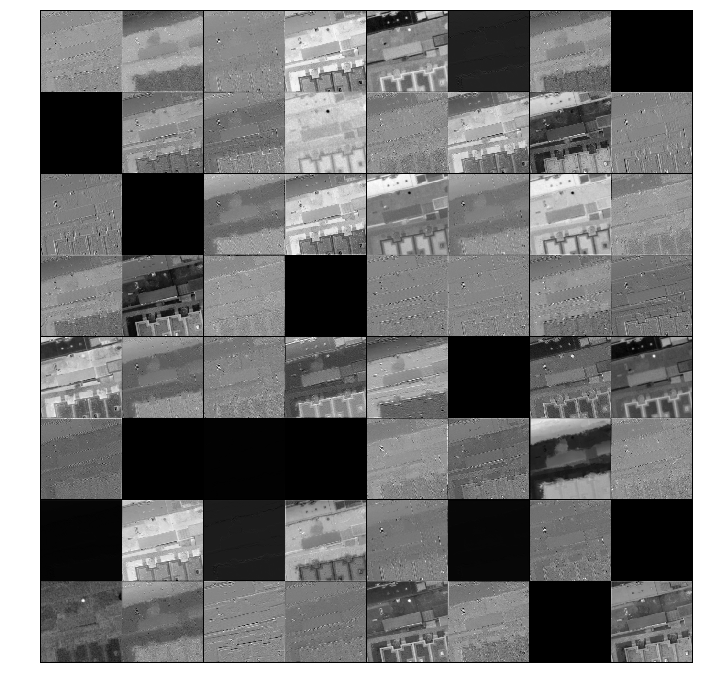

Layer: ReLU(inplace)


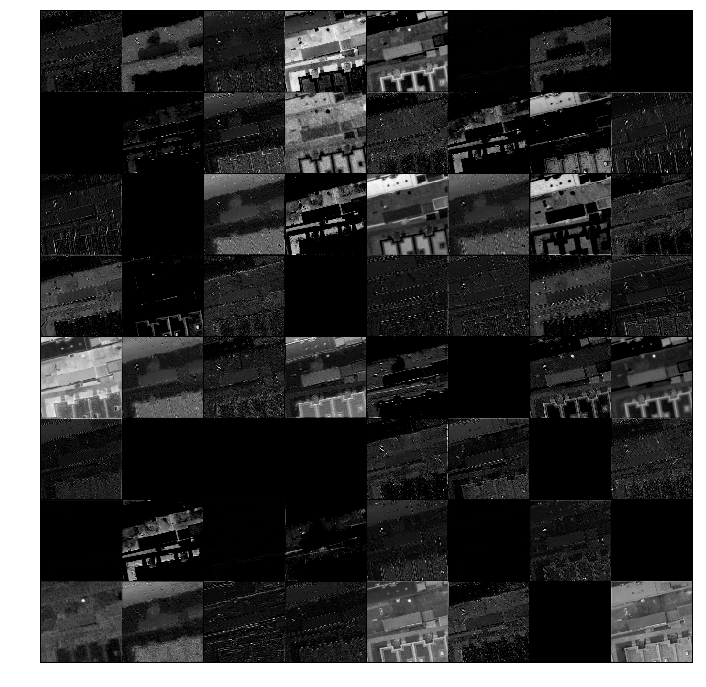

Layer: MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)


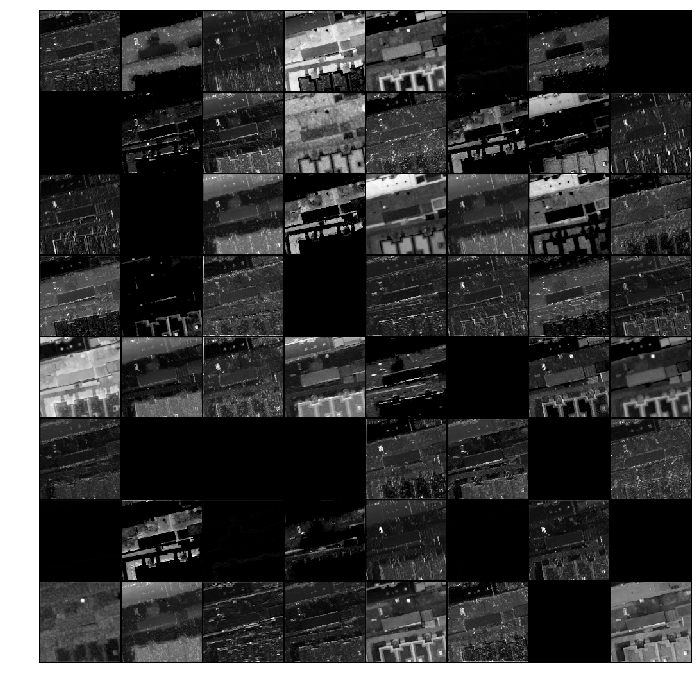

Layer: ASPP(
  (convs): ModuleList(
    (0): Sequential(
      (0): Conv2d(2048, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (1): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU()
    )
    (1): ASPPConv(
      (0): Conv2d(2048, 256, kernel_size=(3, 3), stride=(1, 1), padding=(12, 12), dilation=(12, 12), bias=False)
      (1): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU()
    )
    (2): ASPPConv(
      (0): Conv2d(2048, 256, kernel_size=(3, 3), stride=(1, 1), padding=(24, 24), dilation=(24, 24), bias=False)
      (1): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU()
    )
    (3): ASPPConv(
      (0): Conv2d(2048, 256, kernel_size=(3, 3), stride=(1, 1), padding=(36, 36), dilation=(36, 36), bias=False)
      (1): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU()
    )
    (4)

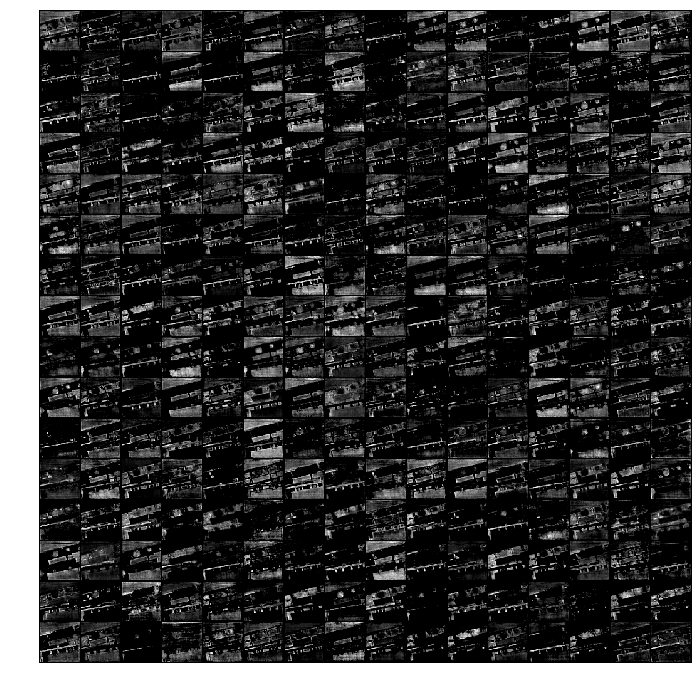

Layer: Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)


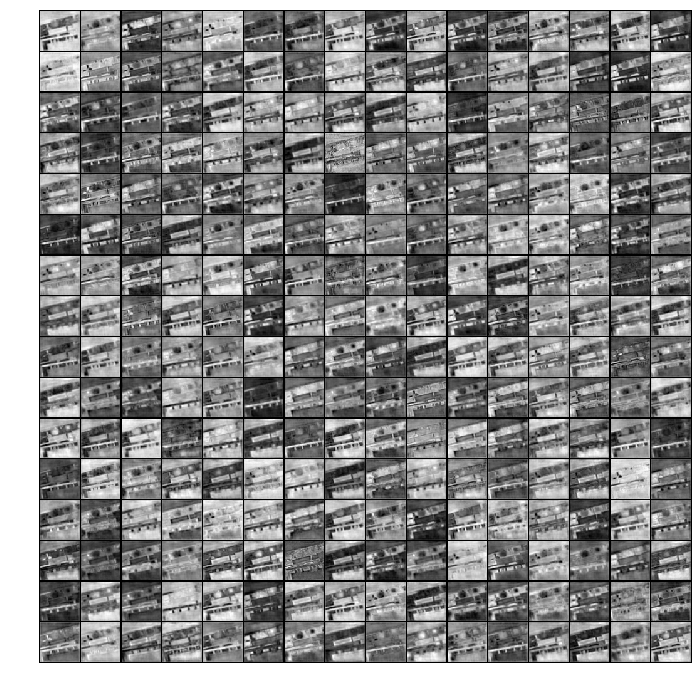

Layer: BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)


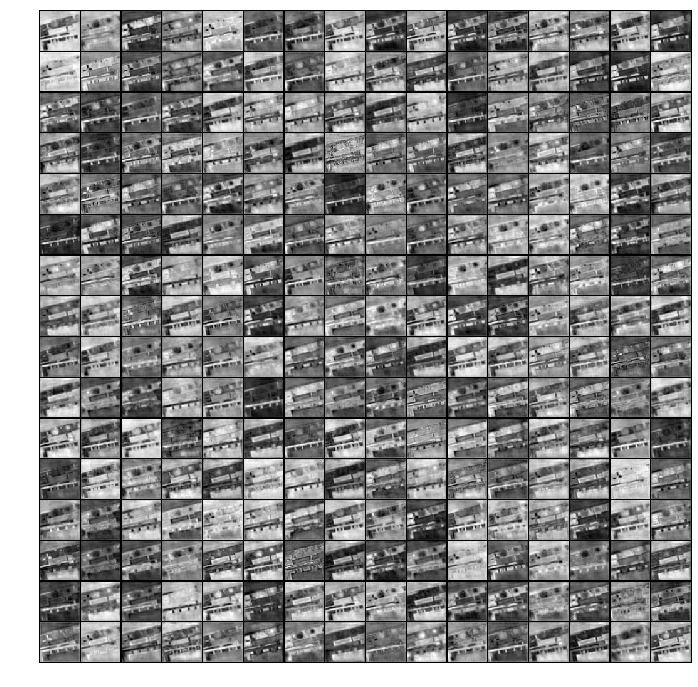

Layer: ReLU()


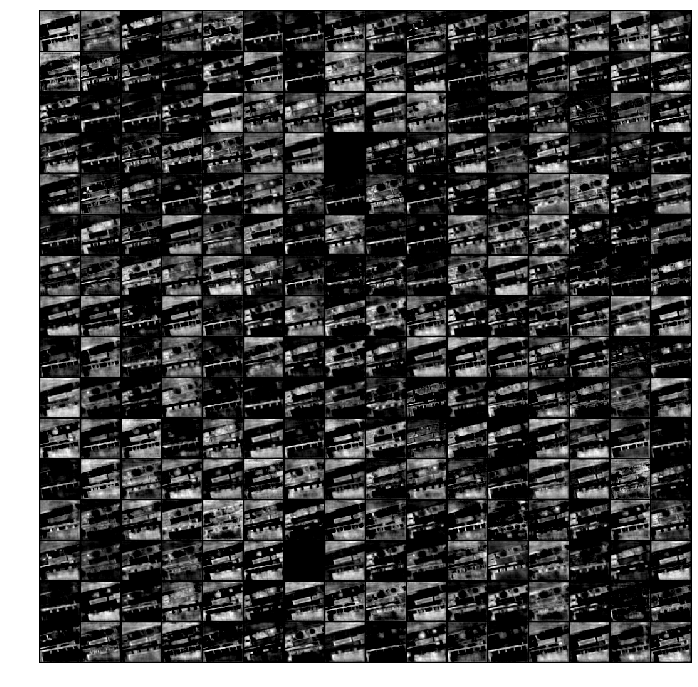

Layer: Conv2d(256, 6, kernel_size=(1, 1), stride=(1, 1))


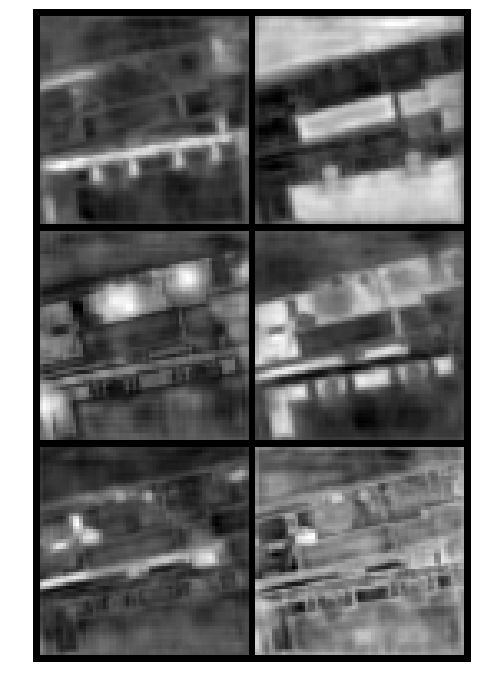

Layer: Conv2d(1024, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)


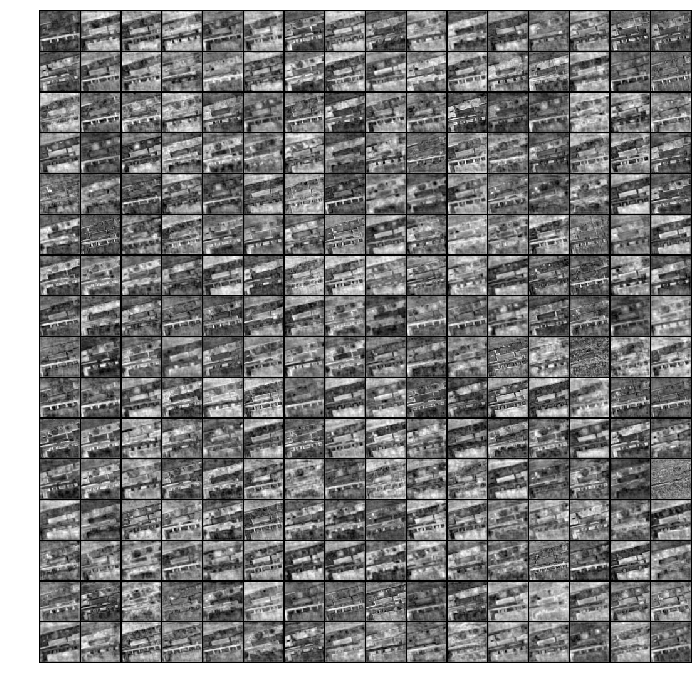

Layer: BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)


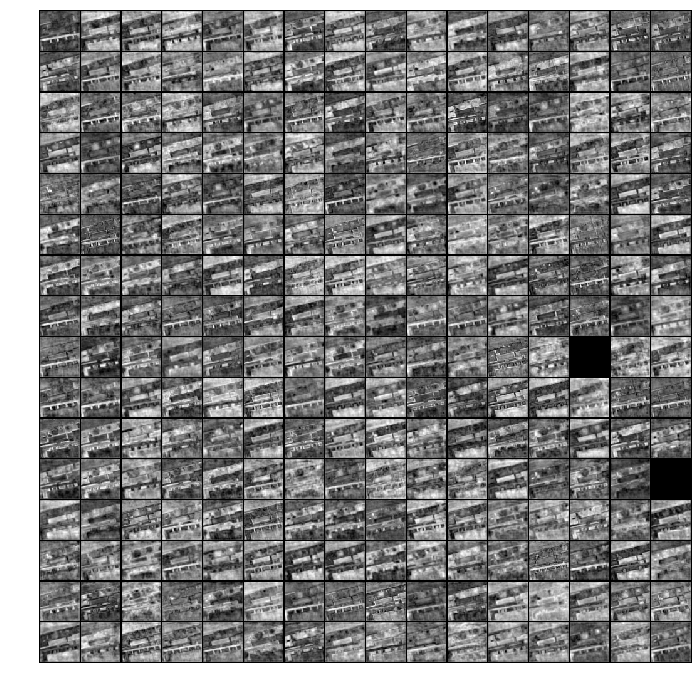

Layer: ReLU()


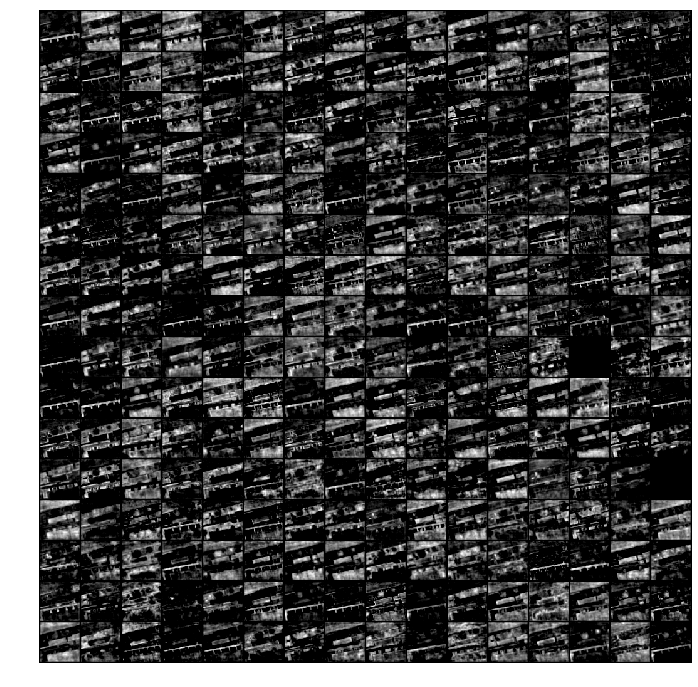

Layer: Dropout(p=0.1)


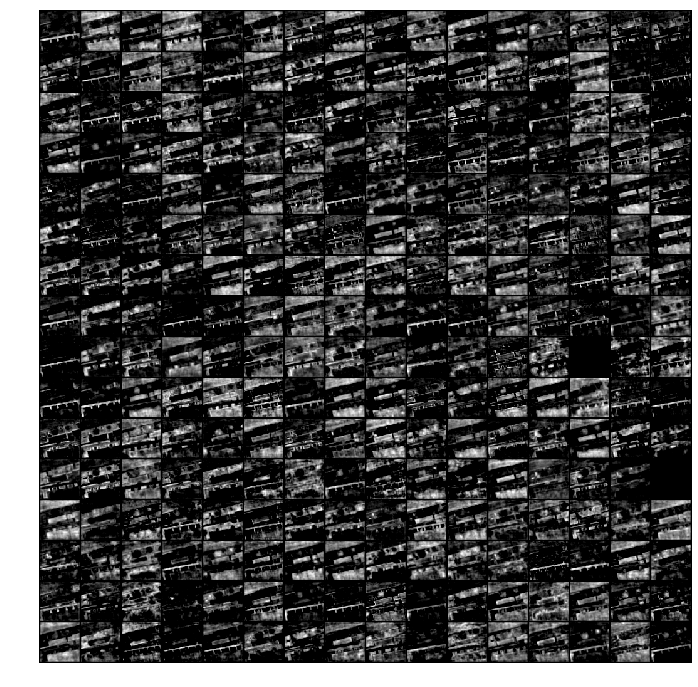

Layer: Conv2d(256, 6, kernel_size=(1, 1), stride=(1, 1))


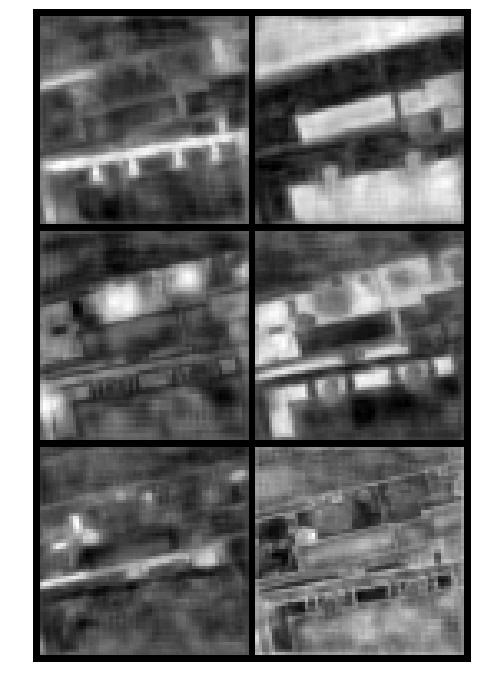

In [0]:
model_debug(model.m, batch_tensor, max_depth=1)

In [0]:
predictions = deeplab_rgbe2coco(batch_tensor[0])['out'].data.cpu().numpy()[0]

In [0]:
predicted_segments = np.apply_along_axis(np.argmax, 0, predictions)
groundtruth_segments = batch_tensor[1].data.cpu().numpy()[0]

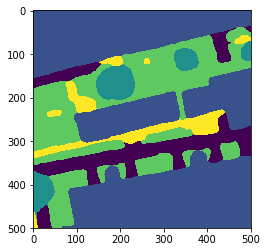

In [0]:
plt.imshow(predicted_segments)

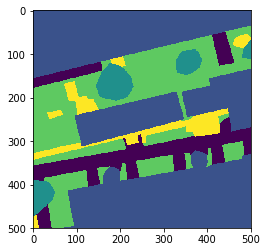

In [0]:
plt.imshow(groundtruth_segments)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


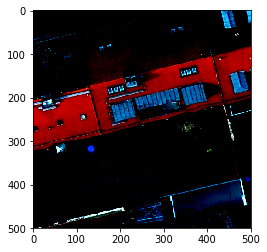

In [0]:
plt.imshow(batch_tensor[0][0].data.cpu().numpy()[0:3,...].transpose(1,2,0))

In [0]:
deeplab_rgbe2coco.backbone.layer1[0].conv1

Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)

In [0]:
deeplab_rgbe2coco.backbone.conv1

Conv2d(4, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)